In [172]:
import numpy as np
import pickle
from pandas import DataFrame, read_csv
from sklearn import preprocessing
from sklearn import metrics as met
import warnings
import tensorflow as tf
from tensorflow.contrib import rnn
import helperModule as hm
import matplotlib.pyplot as plt
from tensorflow import nn
from matplotlib import gridspec

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



In [212]:
#########################
############ Hyperparamter
#########################

st_dev = 0.2
learning_rate = 0.005
training_iters = 30000000
batch_size = 1024
display_step = 100
display_testing_step = 400
dropout_rate = 0.97

n_input = 11 # Number of features
n_steps = 1 # timesteps
n_hidden = 8 # hidden layer num of nodes
n_classes = 5 # KDD99 total classes ( Normal + 4 attack types)


In [131]:
#########################
############ Read in data
#########################

data = pickle.load( open( "kdd99reduced.p", "rb" ) )

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']


In [203]:
tf.reset_default_graph()

tf.set_random_seed(0.5)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Define weights
W = {
    'out': tf.Variable(tf.truncated_normal([n_hidden, n_classes], stddev=st_dev, seed=0.5))
}

b = {
    'out': tf.Variable(tf.zeros([n_classes]))
}

In [204]:
num_layers = 4

def RNN(x, W, b):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)
 
    stacked_rnn = []
    for i in range(num_layers):
        stacked_rnn.append(tf.nn.rnn_cell.LSTMCell(n_hidden, state_is_tuple=True, use_peepholes=True))
    

    lstm_cell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)                
        
    output, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(output[-1], W['out']) + b['out']



In [205]:

pred = RNN(x, W, b)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


In [206]:
# Initializing the variables
init = tf.global_variables_initializer()


In [213]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    losses = {'train':[], 'validation':[]}
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        offset_val = (step * batch_size) % (y_test.shape[0] - batch_size)
        
        # Generate minibatches for training and validating.
        batch_x = x_train[offset:(offset + batch_size), :]
        batch_y = y_train[offset:(offset + batch_size), :]
        batch_val_x = x_test[offset_val:(offset_val + batch_size), :]
        batch_val_y = y_test[offset_val:(offset_val + batch_size), :]
        
        # Reshape data to feed into RNN
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        batch_val_x = batch_val_x.reshape((batch_size, n_steps, n_input))
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        loss_test = sess.run(cost, feed_dict={x: batch_val_x, y: batch_val_y})

        if step % display_step == 0:

            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) +  ", Minibatch Val Loss= " + \
                  "{:.6f}".format(loss_test)
                        
        losses['train'].append(loss)
        losses['validation'].append(loss_test)
        step += 1
            
    print("Optimization Finished!")

    y_pred = sess.run(tf.argmax(pred, 1), feed_dict={x:x_test.reshape((-1, n_steps, n_input)), keep_prob:1.0})
    y_true = np.argmax(y_test,1)
    conf_matrix = met.confusion_matrix(y_true, y_pred)
    
    

Iter 102400, Minibatch Loss= 0.832433, Minibatch Val Loss= 0.851516
Iter 204800, Minibatch Loss= 0.172854, Minibatch Val Loss= 0.172854
Iter 307200, Minibatch Loss= 0.036539, Minibatch Val Loss= 0.036718
Iter 409600, Minibatch Loss= 0.059287, Minibatch Val Loss= 3.525348
Iter 512000, Minibatch Loss= 0.778683, Minibatch Val Loss= 0.639841
Iter 614400, Minibatch Loss= 0.512751, Minibatch Val Loss= 0.512804
Iter 716800, Minibatch Loss= 0.140918, Minibatch Val Loss= 3.724377
Iter 819200, Minibatch Loss= 0.051840, Minibatch Val Loss= 0.051840
Iter 921600, Minibatch Loss= 0.059245, Minibatch Val Loss= 0.060064
Iter 1024000, Minibatch Loss= 0.314317, Minibatch Val Loss= 1.150455
Iter 1126400, Minibatch Loss= 2.350355, Minibatch Val Loss= 0.325038
Iter 1228800, Minibatch Loss= 0.099966, Minibatch Val Loss= 0.104436
Iter 1331200, Minibatch Loss= 2.838027, Minibatch Val Loss= 3.465313
Iter 1433600, Minibatch Loss= 0.043009, Minibatch Val Loss= 0.043009
Iter 1536000, Minibatch Loss= 1.008785, Min

Iter 12288000, Minibatch Loss= 0.035801, Minibatch Val Loss= 0.001440
Iter 12390400, Minibatch Loss= 0.001361, Minibatch Val Loss= 0.001364
Iter 12492800, Minibatch Loss= 0.004469, Minibatch Val Loss= 0.651712
Iter 12595200, Minibatch Loss= 0.001999, Minibatch Val Loss= 0.001999
Iter 12697600, Minibatch Loss= 0.000955, Minibatch Val Loss= 0.000959
Iter 12800000, Minibatch Loss= 0.000787, Minibatch Val Loss= 1.948103
Iter 12902400, Minibatch Loss= 0.047337, Minibatch Val Loss= 0.013140
Iter 13004800, Minibatch Loss= 0.003166, Minibatch Val Loss= 0.003148
Iter 13107200, Minibatch Loss= 0.001692, Minibatch Val Loss= 0.001692
Iter 13209600, Minibatch Loss= 0.000781, Minibatch Val Loss= 0.001708
Iter 13312000, Minibatch Loss= 0.054350, Minibatch Val Loss= 1.571264
Iter 13414400, Minibatch Loss= 0.433578, Minibatch Val Loss= 0.004104
Iter 13516800, Minibatch Loss= 0.002414, Minibatch Val Loss= 0.002414
Iter 13619200, Minibatch Loss= 0.001512, Minibatch Val Loss= 1.464013
Iter 13721600, Minib

Iter 24371200, Minibatch Loss= 0.002299, Minibatch Val Loss= 0.002299
Iter 24473600, Minibatch Loss= 0.001396, Minibatch Val Loss= 0.000647
Iter 24576000, Minibatch Loss= 0.001425, Minibatch Val Loss= 0.001425
Iter 24678400, Minibatch Loss= 0.017383, Minibatch Val Loss= 0.001379
Iter 24780800, Minibatch Loss= 0.005348, Minibatch Val Loss= 0.724884
Iter 24883200, Minibatch Loss= 0.002103, Minibatch Val Loss= 0.695921
Iter 24985600, Minibatch Loss= 0.001334, Minibatch Val Loss= 0.001334
Iter 25088000, Minibatch Loss= 0.001349, Minibatch Val Loss= 1.914844
Iter 25190400, Minibatch Loss= 0.001760, Minibatch Val Loss= 2.275207
Iter 25292800, Minibatch Loss= 0.003625, Minibatch Val Loss= 0.003625
Iter 25395200, Minibatch Loss= 0.001883, Minibatch Val Loss= 1.875071
Iter 25497600, Minibatch Loss= 0.000594, Minibatch Val Loss= 0.235234
Iter 25600000, Minibatch Loss= 0.038463, Minibatch Val Loss= 0.001281
Iter 25702400, Minibatch Loss= 0.000724, Minibatch Val Loss= 1.635023
Iter 25804800, Minib

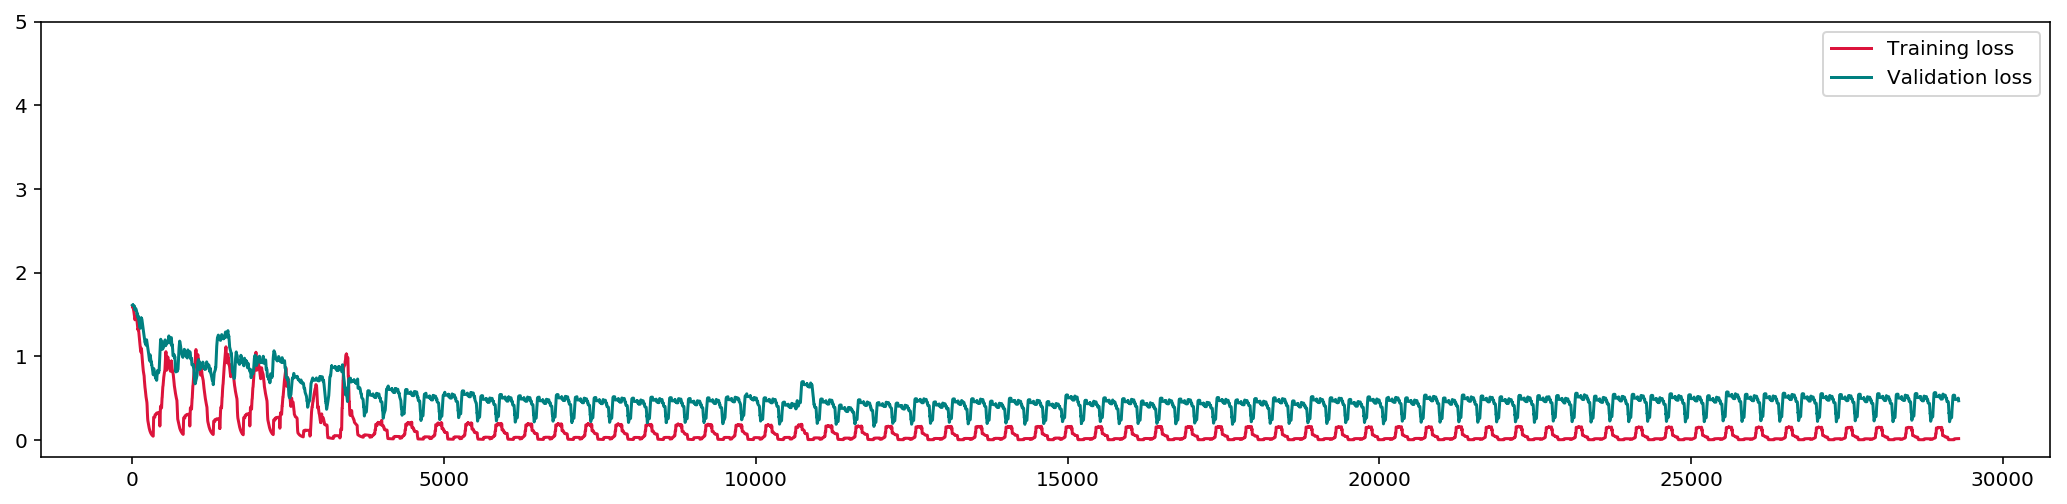

In [209]:

smoothed_loss = hm.running_mean(losses['train'], 100)
smoothed_loss_train = hm.running_mean(losses['validation'], 250)

fig = plt.figure(figsize=(18,4))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:2])

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax1.plot(smoothed_loss_train, label='Validation loss', color='teal')
ax1.legend()
plt.ylim([-0.2,5])
plt.show()

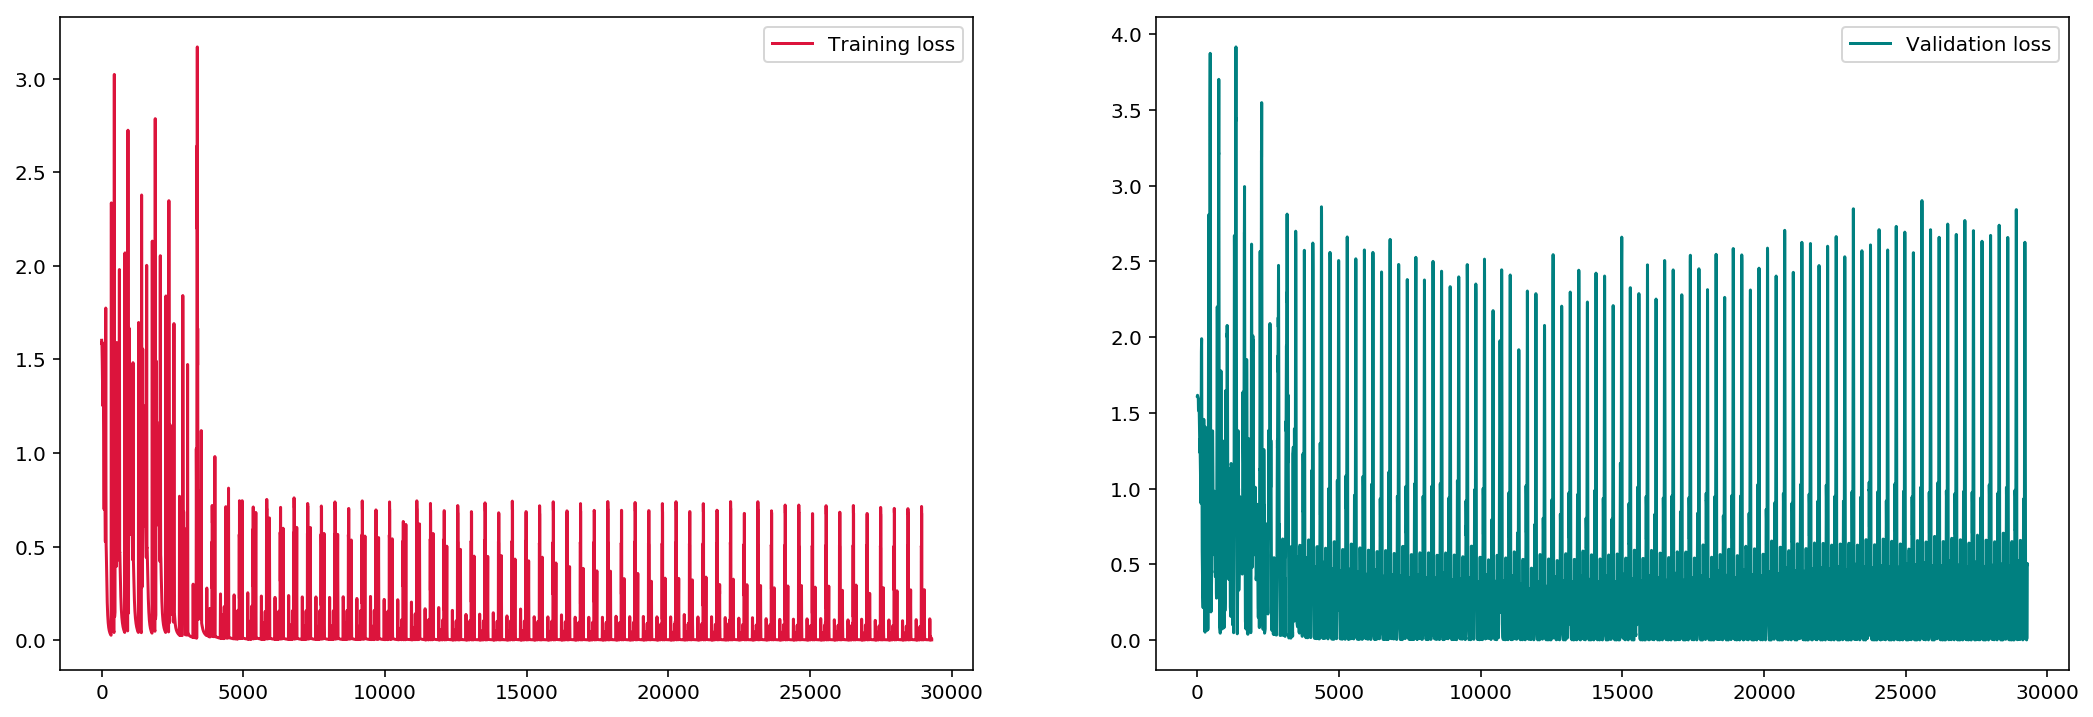

In [210]:
smoothed_loss = hm.running_mean(losses['train'], 10)
smoothed_loss_train = hm.running_mean(losses['validation'], 25)

fig = plt.figure(figsize=(18,6))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:1])
ax2 = plt.subplot(gs[0, 1:])

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax2.plot(smoothed_loss_train, label='Validation loss', color='teal')
ax1.legend()
ax2.legend()

plt.show()

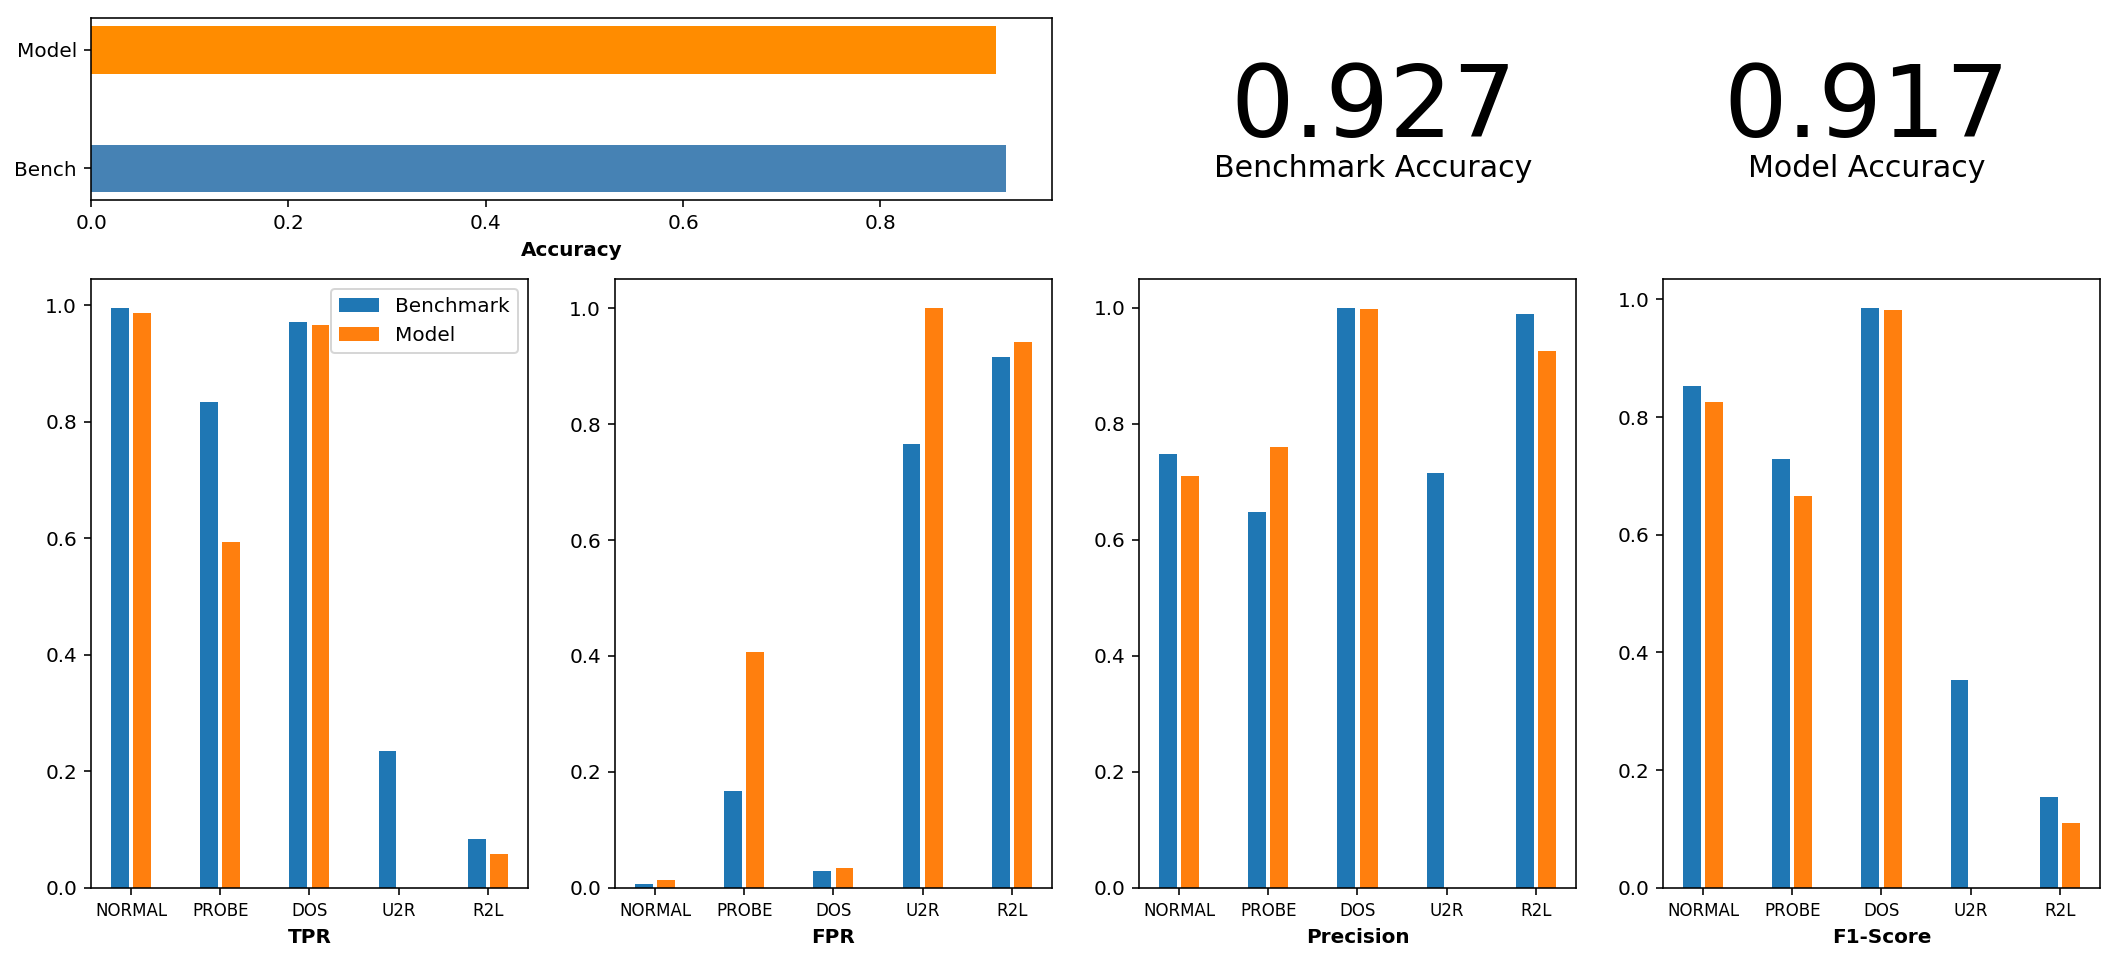

In [211]:
conf_bench = hm.getBenchmarkResults()
metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
hm.plotMetrics(metrics)

